<center>
<span style="font-size: 36px;">YOUTUBE TRENDING VIDEOS INFO.</span>
</center>

In [3]:
# Packages
from googleapiclient.discovery import build
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import MeCab
import re

In [4]:
# Your API key
api_key = 'API_KEY'

In [17]:
# Build the YouTube service
youtube = build('youtube', 'v3', developerKey=api_key)
today = datetime.now().date().strftime('%Y-%m-%d')

In [6]:
# Get trending videos from each region, 50 videos 
def get_trending_videos(region_code='countrycode', max_results=50):
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        chart="mostPopular",
        regionCode=region_code,
        maxResults=max_results
    )
    response = request.execute()
    
    return response 

# Channel info of trending videos
def channel_info(idstr):
    request = youtube.channels().list(
        part="brandingSettings,statistics",
        id = idstr  # Get 1 channel per time, or order is mixed
        )
    response = request.execute()
    return response

In [8]:
# Each video has designated category id
category_id_list = {
    "1": "Film & Animation", "2": "Autos & Vehicles", "10": "Music", "15": "Pets & Animals", "17": "Sports", "18": "Short Movies",
    "19": "Travel & Events", "20": "Gaming", "21": "Videoblogging", "22": "People & Blogs","23": "Comedy", "24": "Entertainment",
    "25": "News & Politics", "26": "Howto & Style", "27": "Education", "28": "Science & Technology", "30": "Movies", "31": "Anime/Animation",
    "32": "Action/Adventure", "33": "Classics", "34": "Comedy", "35": "Documentary", "36": "Drama", "37": "Family", "38": "Foreign",
    "39": "Horror", "40": "Sci-Fi/Fantasy", "41": "Thriller", "42": "Shorts", "43": "Shows", "44": "Trailers"
    }

In [10]:
# Parse the length of the video into different categories
def duration_category(duration_input):
    time_sec = int(pd.Timedelta(duration_input).total_seconds())
    categories = [(60, "< 1min"),(300, "1~5min"),(600, "5~10min"),(1800, "10~30min"),(3600, "30~60min"),(36000, "1~10hrs")]
    # For example, "< 1min" could be movie trailer, "10~30min" could be Vlog, etc
    
    for limit, category in categories:
        if time_sec <= limit:
            return category
    return "> 10hrs"

# Change date format of video uploaded date
def dat_format(date_input):
    date_form = datetime.strptime(date_input, '%Y-%m-%dT%H:%M:%SZ').date()
    return date_form

# Create data table of trending video
def response_to_df(input1,input2):
    video_ids, titles, durations, views, channel_titles, like_counts, category_ids,tags_list, upload_dates, comment_counts,channel_total_view,channel_subscriber,channel_vids, channel_keywords = ([] for _ in range(14))
    for item in input1['items']:
        video_ids.append(item['id'])
        titles.append((re.sub(r'[^\u1100-\u11FF\u3130-\u318F\uAC00-\uD7AF\u3040-\u30FF\u4E00-\u9FFFa-zA-Z0-9 ]', '',item['snippet']['title'])))
        durations.append(duration_category(item['contentDetails']['duration']))
        views.append(int(item['statistics']['viewCount']))
        category_ids.append(category_id_list[item['snippet']['categoryId']])    #convert category id into category name
        channel_titles.append(item['snippet']['channelTitle'])
        like_counts.append(item['statistics'].get('likeCount', None))
        upload_dates.append(dat_format(item['snippet']['publishedAt']))
        comment_counts.append(item['statistics'].get('commentCount', None))
        tags = item['snippet'].get('tags', []) + re.findall(r"#(\w+)",item['snippet']['description'])
        tags_list.append(None if tags == [] else tags)
    
    for i in range(50):
        for ch_info in input2[i]['items']:
            channel_total_view.append(int(ch_info['statistics']['viewCount']))
            channel_subscriber.append(int(ch_info['statistics']['subscriberCount']))
            channel_vids.append(int(ch_info['statistics']['videoCount']))
            keyword = ch_info['brandingSettings']['channel'].get('keywords', '')
            channel_keywords.append([j for j in re.sub(r'[^\u3040-\u30FF\u4E00-\u9FFFa-zA-Z0-9\u1100-\u11FF\u3130-\u318F\uAC00-\uD7AF　]',',',keyword).split(',') if j]if keyword else None)
            
    data = {
        'Video ID':                 video_ids,
        'Title':                    titles,
        'Category' :                category_ids,
        'Views' :                   views,
        'Duration':                 durations,
        'Likes':                    like_counts,
        'Comments':                 comment_counts,
        'Uploaded Date':            upload_dates,
        'Tags':                     tags_list,
        'Channel Title':            channel_titles,
        'Channel Total View':       channel_total_view,
        'Channel Subscribers':      channel_subscriber,
        'Channel Video':            channel_vids,
        'Channel Keywords':         channel_keywords
    }
    
    return pd.DataFrame(data)

In [12]:
# Get info of trending videos
jpresponse = get_trending_videos(region_code='JP', max_results=50)
krresponse = get_trending_videos(region_code='KR', max_results=50)

# Get channel id from video info
krchannelidlist = [krresponse['items'][i]['snippet']['channelId'] for i in range(50)] 
jpchannelidlist = [jpresponse['items'][i]['snippet']['channelId'] for i in range(50)] 

# Get channel info of trending videos
krchannelinfo = [channel_info(i) for i in krchannelidlist]
jpchannelinfo = [channel_info(i) for i in jpchannelidlist]

# Data table
krdf = response_to_df(krresponse,krchannelinfo)
jpdf = response_to_df(jpresponse,jpchannelinfo)

In [210]:
# Convert data table to csv
krdf.to_csv(f'/File/Path/kr{today}.csv', index=False)
jpdf.to_csv(f'/File/Path/jp{today}.csv', index=False)

#JP server
---

In [13]:
jpdf.head()

,Video ID,Title,Category,Views,Duration,Likes,Comments,Uploaded Date,Tags,Channel Title,Channel Total View,Channel Subscribers,Channel Video,Channel Keywords
0,H0S28p3eoWs,Snow ManBREAKOUTMusic Video,Music,7793734,1~5min,142792,13615,2024-06-19,"[Snow Man, スノーマン, 岩本 照, Hikaru Iwamoto, 深澤 辰哉,...",Snow Man,3422123141,3240000,581,"[Snow, Man, snowman, スノーマン]"
1,CQQgfhAsKJc,虫眼鏡てつパパとしパパ爆弾婚約を知る,Comedy,875749,30~60min,21656,1018,2024-06-19,None,東海オンエアの控え室,2892390647,3010000,2279,None
2,GbpRqM9e7u4,Nintendo Direct2024618,Gaming,1836078,30~60min,30331,None,2024-06-18,"[Game, VideoGame, ゲーム, ビデオゲーム, Video Game (Ind...",Nintendo 公式チャンネル,1656187525,2990000,3217,"[Nintendo, 任天堂, にんてんどう, ニンテンドウ, ニンテンドー, YouTub..."
3,MAP3cnAexxM,櫻坂46愛し合いなさい,Music,369182,1~5min,20100,3458,2024-06-19,"[櫻坂46, 櫻坂, 櫻, Nobody's fault, BAN, 流れ弾, 五月雨よ, ...",櫻坂46 OFFICIAL YouTube CHANNEL,1094370983,1160000,398,None
4,LSxnjW49su8,大谷が4年連続の20号チームも9回に5点差ひっくり返す劇的逆転勝利ドジャース vs ロッキー...,Sports,1647159,10~30min,13051,1773,2024-06-19,"[MLB, メジャーリーグ, EPL, プレミアリーグ, SPFL, スコティッシュプレミア...",SPOTVNOW,1114685213,1000000,10040,"[MLB, メジャーリーグ, プレミアリーグ, EPL, spotv, spotv, now]"


In [14]:
# Video from famous / not famous channel
vidrate = [(jpdf['Views'][i]/jpdf['Channel Total View'][i]) for i in range(50)]

# Video index / ratio
vid_from_notfamous_channel = vidrate.index(max(vidrate)) # if close to 0
vid_from_famous_channel = vidrate.index(min(vidrate))# if close to 1 (if bigger than 1 or equal to 1, channel is new)


print("<Video from new or not famous channel>", 
      "\nTitle : ",jpdf.iloc[vid_from_notfamous_channel]['Title'],
      "\nChannel : ",jpdf.iloc[vid_from_notfamous_channel]['Channel Title'],
      "\nRatio : ",max(vidrate),
      "\n\n<Video from famous channel>", 
      "\nTitle : ",jpdf.iloc[vid_from_famous_channel]['Title'],
      "\nChannel : ",jpdf.iloc[vid_from_famous_channel]['Channel Title'],
      "\nRatio : ",min(vidrate)
      )


<Video from new or not famous channel> 
Title :  実家ごはんみんなで食べるごはんは美味しい 
Channel :  井上 咲楽 Sakura Inoue 
Ratio :  0.09602696257961894 

<Video from famous channel> 
Title :  Stray Kids ATE Trailer 
Channel :  JYP Entertainment 
Ratio :  9.88256659171755e-05


#KR server
---

In [15]:
krdf.head()

,Video ID,Title,Category,Views,Duration,Likes,Comments,Uploaded Date,Tags,Channel Title,Channel Total View,Channel Subscribers,Channel Video,Channel Keywords
0,JZ9ysYY-qqI,케이윌 Kwill 내게 어울릴 이별 노래가 없어 MV,Music,1806364,5~10min,179624,22422,2024-06-20,"[Kwill, 브이로그, 윌로그, Kpop, 1theK, Starshiptv, st...",STARSHIP,4828759655,6350000,2219,"[music, singer, kpop, boy, group, girl, group,..."
1,ziLmeVN1_Hs,잉글랜드가 멤버는 화려한데 못하는 이유,Sports,405204,10~30min,7007,872,2024-06-20,"[김진짜, 축구, 잉글랜드, 유로, 유로 2024, 잉글랜드 우승 못하는 이유, 잉...",김진짜 Real KIM,245201889,635000,585,[축구]
2,jJh4UARR4bE,워터밤 시즌 준비 Feat 권은비,Sports,625948,30~60min,8958,770,2024-06-20,"[김종국, 짐종국, 런닝맨, 미우새, 헬스, 운동, 유재석, 하하, 이광수, 송지효...",김종국 GYM JONG KOOK,432248718,3010000,274,"[짐종국, 김종국, 운동, 헬스, 런닝맨, 미우새, 헬창, 축구, 프리미어리그, 건강]"
3,0GTyDijQEUQ,Performance37 RIIZE라이즈 Boom Boom Bass 4K,Entertainment,1130963,1~5min,62601,3370,2024-06-19,"[엠넷, Mnet, 엠투, M2, MPD, 엠피디, Kpop, K-Pop, K팝, ...",M2,9724692347,10000000,23901,"[M2, 엠투, kpop, K팝, mnet, 엠넷, 케이팝, mcountdown, ..."
4,qyvnp3AHMBU,전과자 기피 1호 대학 경찰대학 전과자 ep60 EN,Entertainment,1145997,30~60min,25127,1490,2024-06-20,"[오오디디, 오오티디, ootd, oodf, ootv, 전가자, 전까자, 전꽈, 전...",ootb STUDIO,982068753,1530000,578,"[예능, 고동완, 웹예능, 워크맨, 네고왕, 런닝맨, 또간집, SLL, 달라스튜디오..."


In [16]:
# Video from famous / not famous channel
vidrate = [(krdf['Views'][i]/krdf['Channel Total View'][i]) for i in range(50)]

# Video index / ratio
vid_from_notfamous_channel = vidrate.index(max(vidrate)) # if close to 0
vid_from_famous_channel = vidrate.index(min(vidrate))# if close to 1 (if bigger than 1 or equal to 1, channel is new)


print("<Video from new or not famous channel>", 
      "\nTitle : ",krdf.iloc[vid_from_notfamous_channel]['Title'],
      "\nChannel : ",krdf.iloc[vid_from_notfamous_channel]['Channel Title'],
      "\nRatio : ",max(vidrate),
      "\n\n<Video from famous channel>", 
      "\nTitle : ",krdf.iloc[vid_from_famous_channel]['Title'],
      "\nChannel : ",krdf.iloc[vid_from_famous_channel]['Channel Title'],
      "\nRatio : ",min(vidrate)
      )


<Video from new or not famous channel> 
Title :  SUB 환승연애3 첫 단체 강릉여행 
Channel :  헤이유정 YUJUNG 
Ratio :  1.0355544130697465 

<Video from famous channel> 
Title :  Seventeen Last Night Live Performance  Genius Open Mic 
Channel :  Genius 
Ratio :  8.966069152610585e-05


#Graph
---

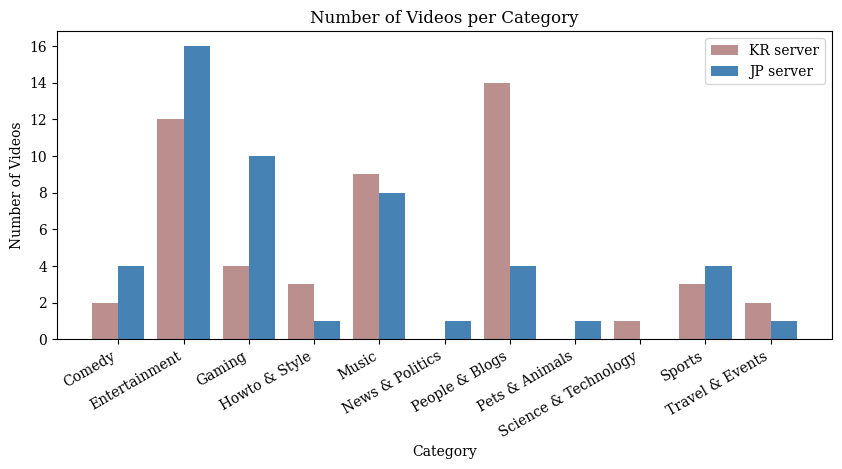

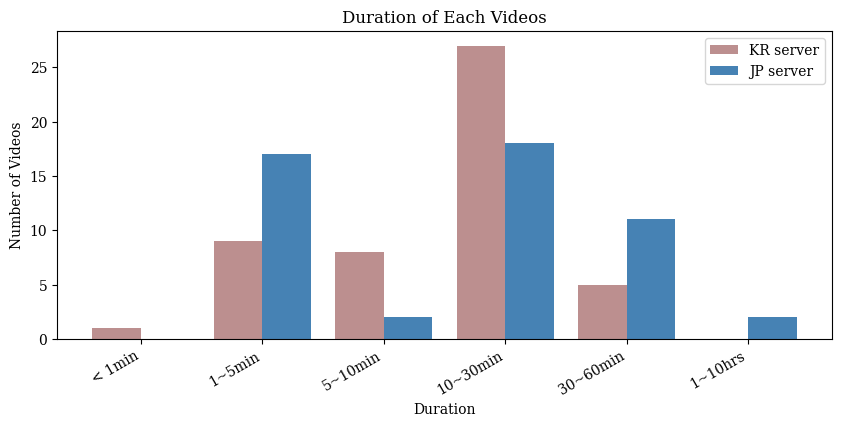

In [23]:
# Category Counter
category_countskr = krdf['Category'].value_counts()
category_countsjp = jpdf['Category'].value_counts()
all_categories = category_countskr.combine_first(category_countsjp).index
category_countskr = category_countskr.reindex(all_categories, fill_value=0)
category_countsjp = category_countsjp.reindex(all_categories, fill_value=0)
index = np.arange(len(all_categories))

# Plot
plt.rcParams["font.family"] = "DejaVu Serif"
plt.figure(figsize=(10, 4))
plt.bar(index - 0.2, category_countskr.values, width=0.4, label='KR server',color = 'rosybrown')
plt.bar(index + 0.2, category_countsjp.values, width=0.4, label='JP server',color = 'steelblue')
plt.xlabel('Category')
plt.ylabel('Number of Videos')
plt.title('Number of Videos per Category')
plt.xticks(index, all_categories, rotation=30, ha='right')
plt.legend()
plt.show()

# Video length Counter
category_countskr = krdf['Duration'].value_counts()
category_countsjp = jpdf['Duration'].value_counts()
desired_order = ["< 1min", "1~5min", "5~10min", "10~30min", "30~60min", "1~10hrs"]
category_countskr = category_countskr.reindex(desired_order, fill_value=0)
category_countsjp = category_countsjp.reindex(desired_order, fill_value=0)
index = np.arange(len(desired_order))

# Plot
plt.figure(figsize=(10, 4))
plt.bar(index - 0.2, category_countskr.values, width=0.4, label='KR server',color = 'rosybrown')
plt.bar(index + 0.2, category_countsjp.values, width=0.4, label='JP server',color = 'steelblue')
plt.xlabel('Duration')
plt.ylabel('Number of Videos')
plt.title('Duration of Each Videos')
plt.xticks(index, desired_order, rotation=30, ha='right')
plt.legend()
plt.show()